-------------- Calibrating --------------
data/calibration_images/left*.png
data/calibration_images/right*.png
--------------- Remapping ----------------


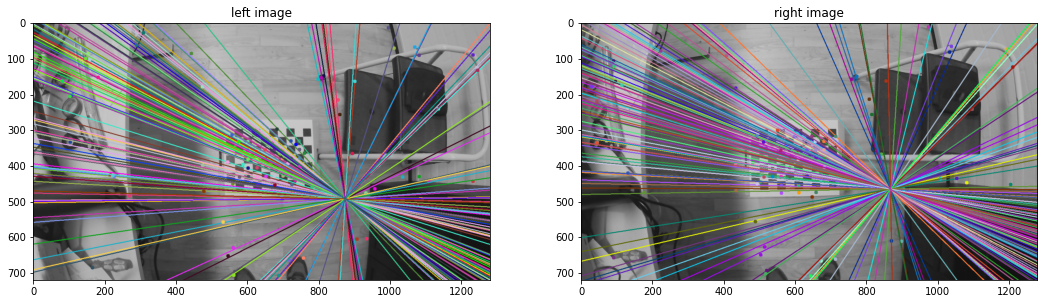

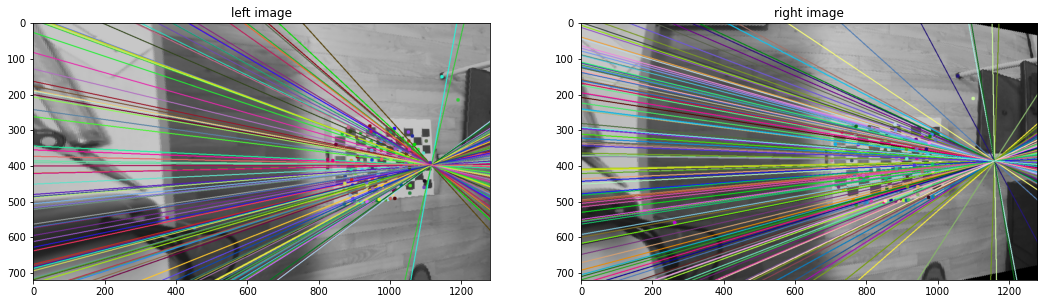

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt



class Calibration:
    def __init__(self, img_path, nb_vertical, nb_horizontal):
        # setup for the calibration images
        self.PATH = img_path
        self.pattern_size = (nb_vertical, nb_horizontal)
        
        self.img_shape = None
        # for distorsion
        self.objpoints = [] 

        self.left_mtx = None
        self.left_dist = None
        self.left_roi = None
        self.left_cameramtx = None
        self.left_imgpoints = None

        self.right_mtx = None
        self.right_dist = None
        self.right_roi = None
        self.right_cameramtx = None
        self.right_imgpoints = None
        
        self.left_map = None
        self.right_map = None


    def calibrate(self, Show = False):
        
        #calibrate left camera
        ind = self.PATH.find("*")
        path = self.PATH[0:ind] + "left" + self.PATH[ind:]
        print(path)
        self.left_mtx, self.left_dist, self.left_roi, self.left_cameramtx, self.left_imgpoints = self._calibrate(path,Show)

        #calibrate the right camera
        path = self.PATH[0:ind] + "right" + self.PATH[ind:]
        print(path)
        self.right_mtx, self.left_dist, self.left_roi, self.left_cameramtx, self.right_imgpoints = self._calibrate(path,Show)
        
        self._rectify(self.img_shape,Show)

    def _calibrate(self, Path, Show):
        
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((self.pattern_size[0]*self.pattern_size[1],3), np.float32)
        objp[:,:2] = np.mgrid[0:self.pattern_size[0],0:self.pattern_size[1]].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d point in real world space
        imgpoints = [] # 2d points in image plane.
        
        # Load the images
        images = glob.glob(Path)
        assert images
        
        # perform calibration for left images only
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            #Implement findChessboardCorners here
            ret, corners = cv2.findChessboardCorners(img, self.pattern_size)

            # If found, add object points, image points (after refining them)
            if ret == True:
                self.objpoints.append(objp)
                imgpoints.append(corners)

        if Show == True:
            img = cv2.drawChessboardCorners(img, (self.pattern_size[0],self.pattern_size[1]), corners,ret)
            cv2.imshow('img',img)
            cv2.waitKey(0)
                                                
        
        h, w = img.shape[:2]
        self.img_shape = gray.shape[::-1] 
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, imgpoints, self.img_shape, None, None)
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),0,(w,h))
    
        return mtx, dist, roi, newcameramtx, imgpoints

    def distort_img(self, img, Crop = False):

        #get undistortet image
        dst = cv2.undistort(img, self.left_mtx, self.left_dist, None, self.left_cameramtx)

        #crop if needed
        if Crop == True:
            x,y,w,h = self.left_roi
            dst = dst[y:y+h, x:x+w]
        return dst

    def _rectify(self, dims, Show = False):
        flags = 0
        flags |= cv2.CALIB_FIX_INTRINSIC
        # flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
        flags |= cv2.CALIB_USE_INTRINSIC_GUESS
        flags |= cv2.CALIB_FIX_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_ASPECT_RATIO
        flags |= cv2.CALIB_ZERO_TANGENT_DIST
        # flags |= cv2.CALIB_RATIONAL_MODEL
        # flags |= cv2.CALIB_SAME_FOCAL_LENGTH
        # flags |= cv2.CALIB_FIX_K3
        # flags |= cv2.CALIB_FIX_K4
        # flags |= cv2.CALIB_FIX_K5
        stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER +                                                                                                                                                cv2.TERM_CRITERIA_EPS, 100, 1e-5)
                                                             
        ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(self.objpoints, self.left_imgpoints,
                                                              self.right_imgpoints, self.left_mtx, self.left_dist, 
                                                              self.right_mtx,self.right_dist, dims,
                                                              criteria=stereocalib_criteria, flags=flags)
        
        R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(M1,d1,M2,d2,dims,R,T) 
        
        self.left_map = cv2.initUndistortRectifyMap(M1,d1,R1,P1,dims,0)
        self.right_map = cv2.initUndistortRectifyMap(M2,d2,R2,P2,dims,0)


    def _drawlines(self, img1,img2,lines,pts1,pts2):
        ''' img1 - image on which we draw the epilines for the points in img2
            lines - corresponding epilines '''
        r,c = img1.shape
        img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
        img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
        for r,pt1,pt2 in zip(lines,pts1,pts2):
            color = tuple(np.random.randint(0,255,3).tolist())
            x0,y0 = map(int, [0, -r[2]/r[1] ])
            x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
            img1 = cv2.line(img1, (x0,y0), (x1,y1), color,2)
            img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
            img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
        return img1,img2
        
    def left_remap(self,img):
        return cv2.remap(img,self.left_map[0],self.left_map[1],cv2.INTER_NEAREST, cv2.BORDER_CONSTANT)


    def right_remap(self,img):
        return cv2.remap(img,self.right_map[0],self.right_map[1],cv2.INTER_NEAREST, cv2.BORDER_CONSTANT)

    def draw_epilines(self,left_img,right_img, nb_matches = 200):
        left_img = cv2.cvtColor(left_img,cv2.COLOR_BGR2GRAY)
        right_img = cv2.cvtColor(right_img,cv2.COLOR_BGR2GRAY)

        sift = cv2.xfeatures2d.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(left_img, None)
        kp2, des2 = sift.detectAndCompute(right_img, None)

        # create BFMatcher object
        bf = cv2.BFMatcher()
        # Match descriptors.
        matches = bf.match(des1,des2)


        # Sort them in the order of their distance (i.e. best matches first).
        matches = sorted(matches, key = lambda x:x.distance)

        good = []
        pts1 = []
        pts2 = []

        for m in matches[:nb_matches]:
                good.append(m)
                pts1.append(kp1[m.queryIdx].pt)
                pts2.append(kp2[m.trainIdx].pt)

        pts1 = np.int32(pts1)
        pts2 = np.int32(pts2)
                            

        #Implement findFundamentalMat here:
        F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_8POINT)

        # We select only inlier points
        pts1 = pts1[mask.ravel() == 1]
        pts2 = pts2[mask.ravel() == 1]

        # Find epilines corresponding to points in right image (second image) and
        # drawing its lines on left image
        lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2 ,F)
        lines1 = lines1.reshape(-1, 3)
        img5, img6 = self._drawlines(left_img, right_img, lines1, pts1, pts2)

        # Find epilines corresponding to points in left image (first image) and
        # drawing its lines on right image
        lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
        lines2 = lines2.reshape(-1, 3)
        img3, img4 = self._drawlines(right_img, left_img, lines2, pts2, pts1)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
        ax[0].imshow(img5)
        ax[0].set_title('left image')
        ax[1].imshow(img3)
        ax[1].set_title('right image')


if __name__ == "__main__":
    # test code

    cali = Calibration("data/calibration_images/*.png", 6, 9)
    print("-------------- Calibrating --------------")
    cali.calibrate()
    
    img_left = cv2.imread("data/calibration_images/left-0001.png")
    img_right = cv2.imread("data/calibration_images/right-0001.png")
    cali.draw_epilines(img_left,img_right)
    
    print("--------------- Remapping ----------------")
    dst_left = cali.left_remap(img_left)
    dst_right = cali.right_remap(img_right)
    cali.draw_epilines(dst_left,dst_right)
    plt.show()